In [1]:
import ee
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import geemap.foliumap as geemap
import sys
import folium
import seaborn as sns
import ast
import datetime

sys.path.append('../../')
sns.set_style('whitegrid')

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Patch
from src.data.ee_utils import *
from src.data.data_utils import *
from src.data.dataset import *
# from src.models.model_utils import *
from src.data.classes import LUCAS2018_LEVEL2_CODES, LUCAS_10_COLORS, BANDS

ee.Authenticate()
ee.Initialize()

/u/ayang1/.conda/envs/CropTS/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
#=========Load Data=========
data_dir = '/scratch/bbug/ayang1/datasets/lucas_fused_10/'
# fused_data = process_fused_data(data_dir)
# fused_data.to_csv(os.path.join(data_dir, 'fused_data.csv'), index=False)
fused_data = pd.concat([pd.read_csv(os.path.join(data_dir, 'train.csv')), pd.read_csv(os.path.join(data_dir, 'test.csv')), pd.read_csv(os.path.join(data_dir, 'val.csv'))])

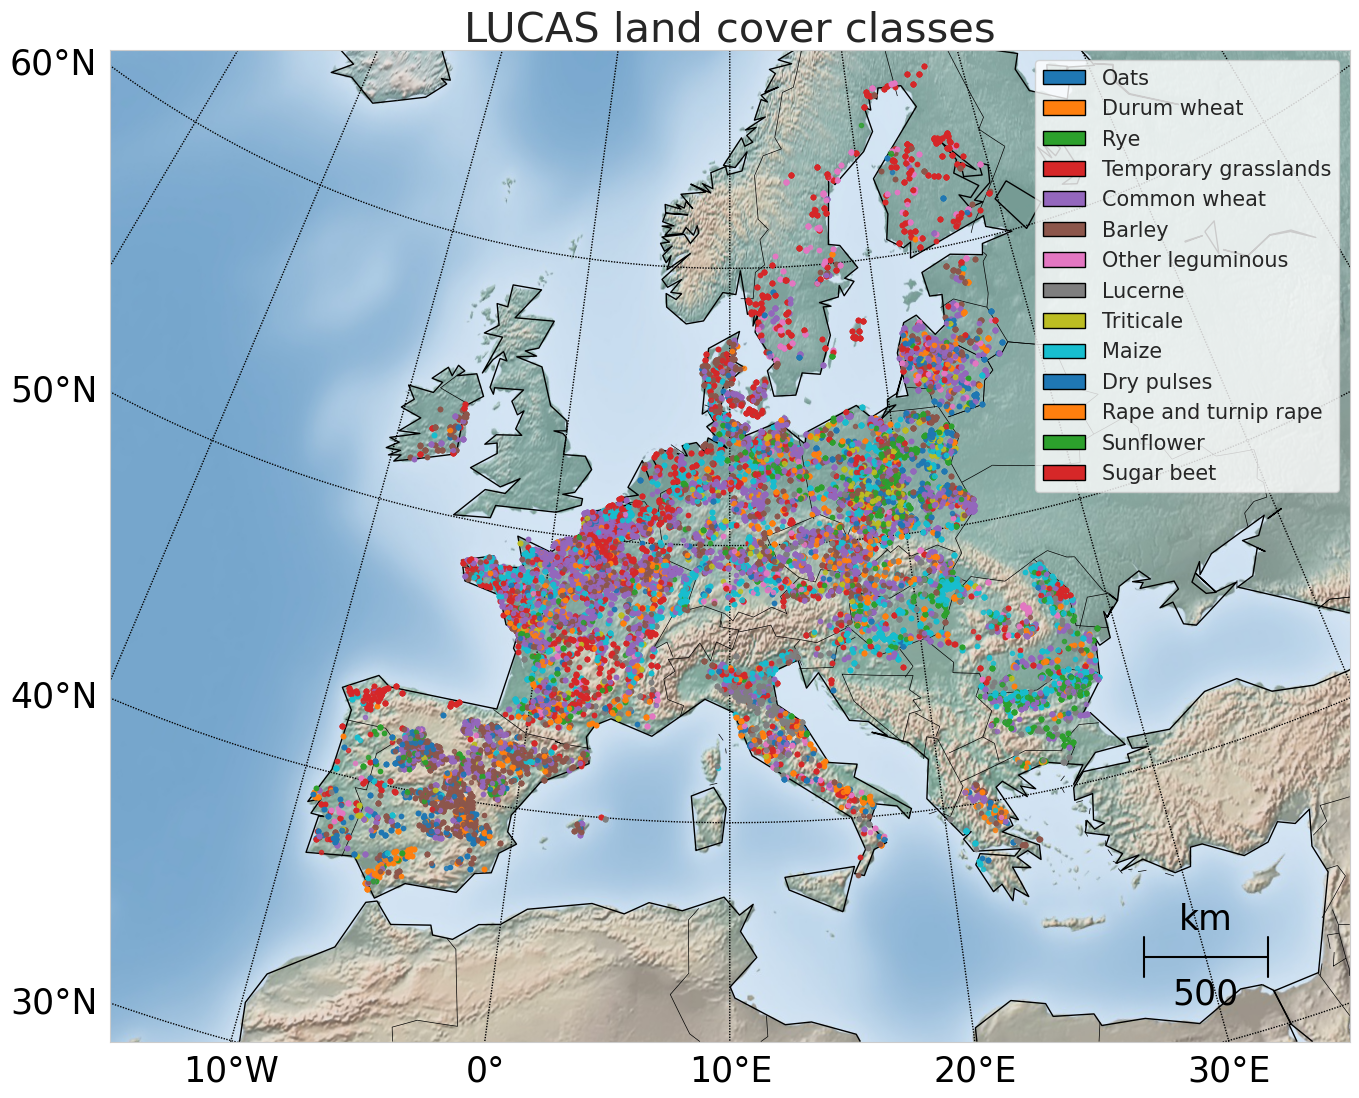

In [12]:
# Create a new figure for Basemap
plt.figure(figsize=(16, 16))
title_font=30
legend_font=15
axis_font=25

#=========Map Setup=========
# Initialize the Basemap for Europe
m = Basemap(projection='lcc', resolution='c', lat_0=50, lon_0=10, width=5E6, height=4E6)
m.drawcountries()
m.drawcoastlines()
m.shadedrelief()

# Draw latitude and longitude lines
m.drawparallels(np.arange(-80., 81., 10.), labels=[True, False, False, False], fontsize=axis_font)
m.drawmeridians(np.arange(-180., 181., 10.), labels=[False, False, False, True], fontsize=axis_font)

# You may need to adjust these values to fit the scale bar within your map
scale_lon = 30  # Adjust this to move the scale bar left or right
scale_lat = 33  # Adjust this to move the scale bar up or down
m.drawmapscale(lon=scale_lon, lat=scale_lat, lon0=10, lat0=50, length=500, barstyle='simple', units='km', fontsize=axis_font)

#=========Plotting=========
cmap = sns.color_palette('tab10', len(fused_data['LABEL'].unique()))
colors = LUCAS_10_COLORS

for index, row in fused_data.iterrows():
    geom = ast.literal_eval(row['geo'])
    x, y = m(geom['coordinates'][0], geom['coordinates'][1])
    plt.plot(x, y, marker='o',color=colors[row['LABEL']], markersize=3, alpha=0.8)
    
legend_elements = [Patch(facecolor=colors[crop], edgecolor='black',
                     label=LUCAS2018_LEVEL2_CODES[crop]) for crop in colors.keys()]
plt.legend(handles=legend_elements, loc='upper right', fontsize=legend_font)
plt.title('LUCAS land cover classes', fontsize=title_font)
plt.show()
# plt.savefig('./LUCAS_plot.png')

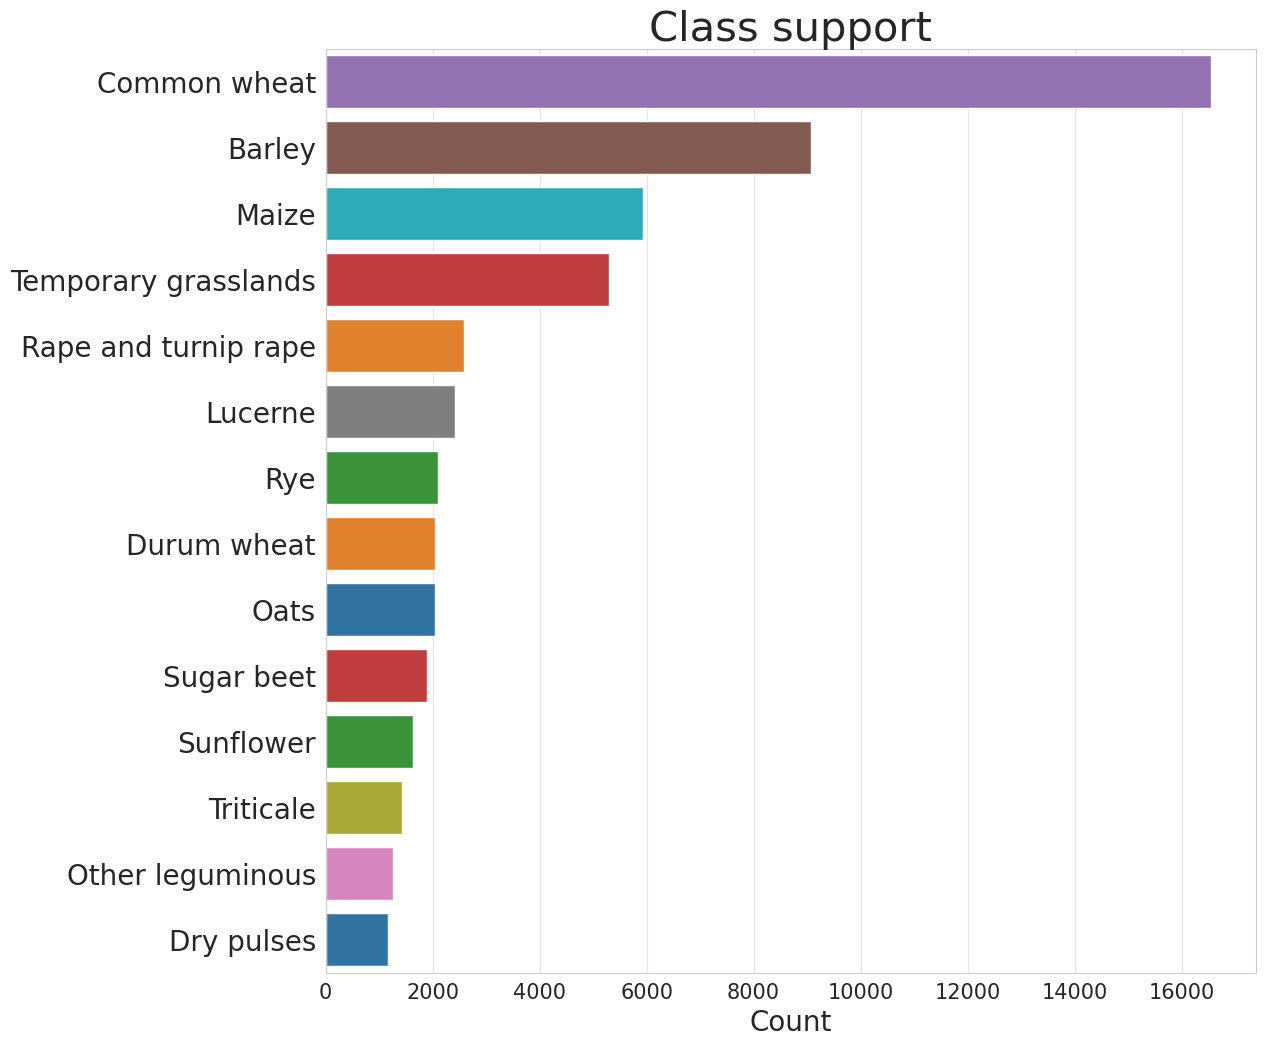

In [11]:
plt.figure(figsize=(12, 12))

title_font=30
legend_font=20
y_axis_font=20
x_axis_font=15

# Get the unique values and their counts
unique_values, counts = np.unique(fused_data['LABEL'], return_counts=True)
count_sort_ind = np.argsort(-counts)
unique_values, counts = unique_values[count_sort_ind], counts[count_sort_ind]
crop_colors = [colors[x] for x in unique_values]

plt.title('Class support', fontsize=title_font)
# Create a bar plot
sns.barplot(y=unique_values, x=counts, orient='h', palette=crop_colors, hue=unique_values)

legend_elements = [Patch(facecolor=colors[crop], edgecolor='black',
                     label=crop) for crop in colors.keys()]

plt.yticks(range(len(unique_values)), [LUCAS2018_LEVEL2_CODES[x] for x in unique_values], fontsize=y_axis_font)
plt.xticks(fontsize=x_axis_font)
plt.grid(axis='x', alpha=0.5)
plt.xlabel('Count', fontsize=legend_font)
plt.show()

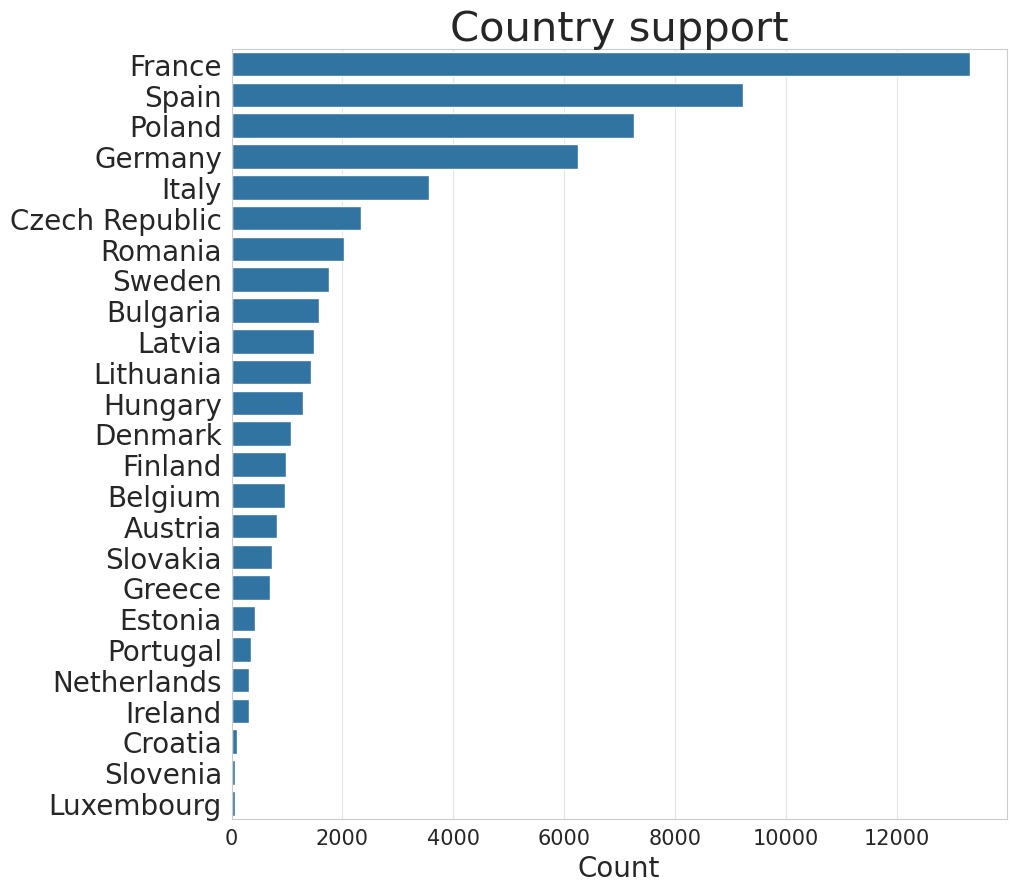

In [5]:
plt.figure(figsize=(10, 10))

title_font=30
legend_font=20
y_axis_font=20
x_axis_font=15

# Get the unique values and their counts
unique_values, counts = np.unique(fused_data['country'], return_counts=True)
count_sort_ind = np.argsort(-counts)
unique_values, counts = unique_values[count_sort_ind], counts[count_sort_ind]

plt.title('Country support', fontsize=title_font)
# Create a bar plot
sns.barplot(y=unique_values, x=counts)

plt.yticks(range(len(unique_values)), unique_values, fontsize=y_axis_font)
plt.xticks(fontsize=x_axis_font)
plt.grid(axis='x', alpha=0.5)
plt.xlabel('Count', fontsize=legend_font)
plt.show()

In [27]:
title_font=30
legend_font=20
y_axis_font=20
x_axis_font=15

finetuning = {
    'Full finetuning': 0.8945,
    'Lora': 0.6710,
    'Linear probing': 0.6206
}

moment_limited = {
    36: 0.8945,
    30: 0.8774,
    24: 0.8582,
    18: 0.7607,
    12:  0.4582
}

RF_limited = {
    36: 0.8418,
    30:  0.8390,
    24: 0.8282,
    18: 0.8032,
    12: 0.7423
}


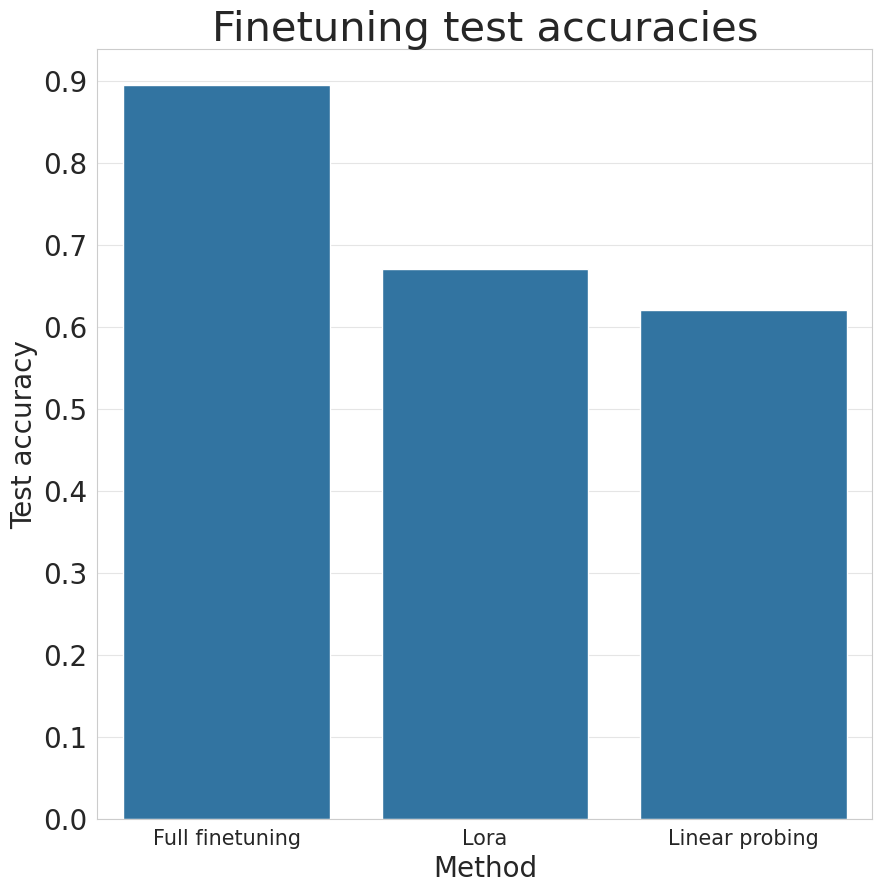

In [7]:
plt.figure(figsize=(10, 10))
plt.title('Finetuning test accuracies', fontsize=title_font)
# Create a bar plot
sns.barplot(y=finetuning.values(), x=range(3))

plt.xticks(range(3), finetuning.keys(), fontsize=x_axis_font)
plt.yticks(np.arange(0, 1, 0.1), fontsize=legend_font)
plt.xlabel('Method', fontsize=y_axis_font)
plt.ylabel('Test accuracy', fontsize=y_axis_font)
plt.grid(axis='y', alpha=0.5)
plt.show()

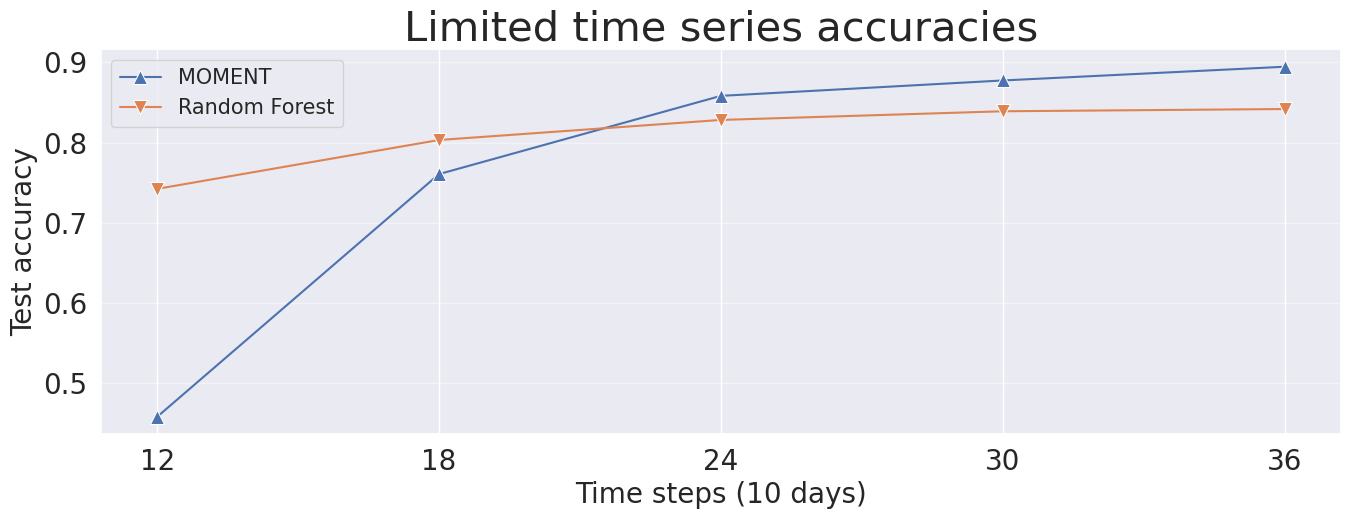

In [35]:

title_font=30
legend_font=15
axis_font=20

plt.figure(figsize=(16, 5))
plt.title('Limited time series accuracies', fontsize=title_font)
# Create a bar plot
sns.lineplot(x=moment_limited.keys(), y=moment_limited.values(), label='MOMENT', marker='^', markersize=10)
sns.lineplot(x=RF_limited.keys(), y=RF_limited.values(), label='Random Forest', marker='v', markersize=10)

plt.xticks(list(moment_limited.keys()), fontsize=axis_font)
plt.yticks(np.arange(0.5, 1, 0.1), fontsize=axis_font)
plt.xlabel('Time steps (10 days)', fontsize=axis_font)
plt.ylabel('Test accuracy', fontsize=axis_font)
plt.legend(fontsize=legend_font)
plt.grid(axis='y', alpha=0.5)
plt.show()

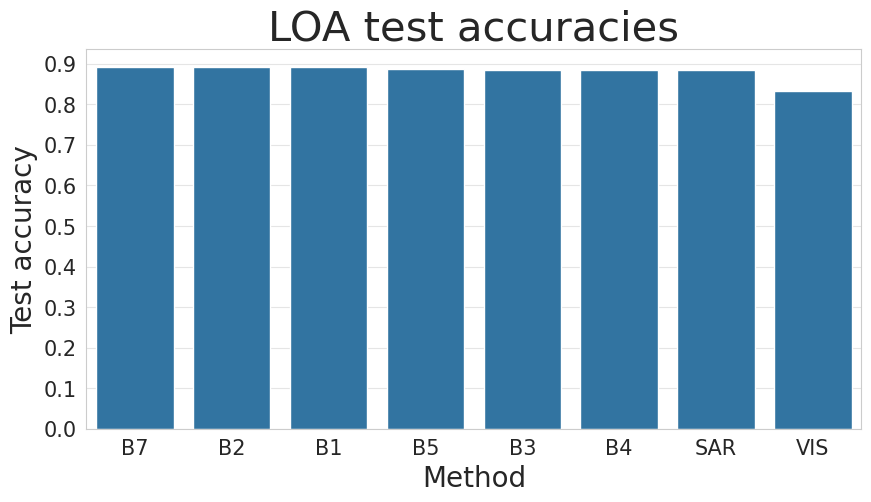

In [9]:
loa_results = {
    'B7': 0.8925,
    'B2': 0.8916,
    'B1': 0.8916,
    'B5': 0.8874,
    'B3': 0.8854,
    'B4': 0.8854,
    'SAR': 0.8854,
    'VIS': 0.8319
}

title_font=30
legend_font=20
y_axis_font=20
x_axis_font=15

plt.figure(figsize=(10, 10))
plt.title('LOA test accuracies', fontsize=title_font)
# Create a bar plot
sns.barplot(y=loa_results.values(), x=range(8))

plt.xticks(range(8), loa_results.keys(), fontsize=x_axis_font)
plt.yticks(np.arange(0, 1, 0.1), fontsize=x_axis_font)
plt.xlabel('Method', fontsize=y_axis_font)
plt.ylabel('Test accuracy', fontsize=y_axis_font)
plt.grid(axis='y', alpha=0.5)
plt.subplots_adjust(bottom=0.5)
plt.show()

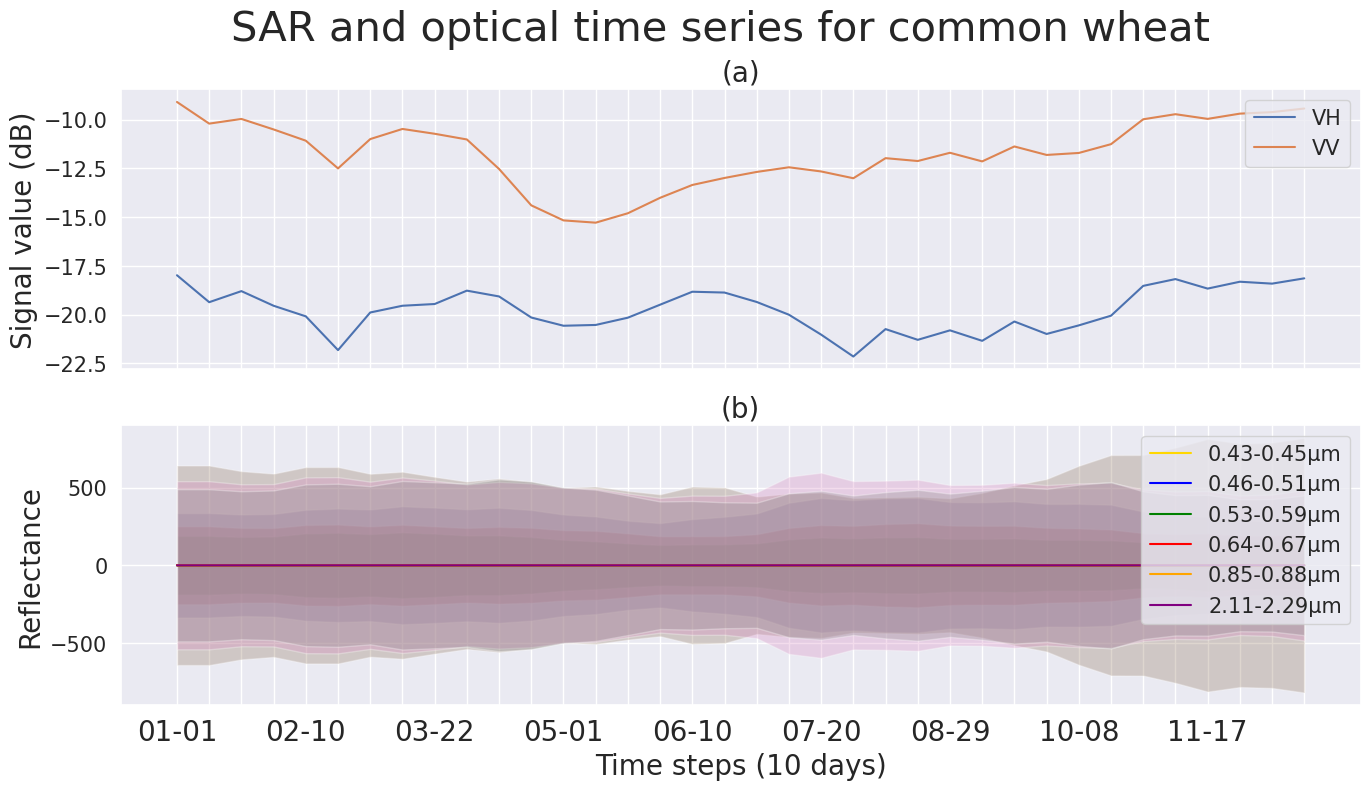

In [36]:
from tkinter import font
from matplotlib import axis
import numpy as np
import datetime

common_wheat = fused_data[fused_data['LABEL'] == 'B11']
bands = get_band_arrays(common_wheat, BANDS, lambda x: int(x.split('_')[0]))

fig, ax = plt.subplots(figsize=(16, 8), nrows=2, ncols=1, sharex=True)

title_font=30
legend_font=15
axis_font=20
scale_factor=0.0001

for band in ['VH', 'VV']:
    mean = bands[band].mean(axis=0)
    std = bands[band].std(axis=0)
    sns.lineplot(mean, label=band, ax=ax[0])
    plt.fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.3)

# band_vis = {
#     'B1': ('yellow', 'Coastal aerosol (0.43-0.45\u03bcm)'),
#     'B2': ('blue', 'Blue (0.46-0.51\u03bcm)'),
#     'B3': ('green', 'Green (0.53-0.59\u03bcm)'),
#     'B4': ('red', 'Red (0.64-0.67\u03bcm)'),
#     'B5': ('orange', 'Near infrared (0.85-0.88\u03bcm)'),
#     'B7': ('purple', 'Shortwave infrared 2 (2.11-2.29\u03bcm)')
# }
band_vis = {
    'B1': ('gold', '0.43-0.45\u03bcm'),
    'B2': ('blue', '0.46-0.51\u03bcm'),
    'B3': ('green', '0.53-0.59\u03bcm'),
    'B4': ('red', '0.64-0.67\u03bcm'),
    'B5': ('orange', '0.85-0.88\u03bcm'),
    'B7': ('purple', '2.11-2.29\u03bcm')
}


for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']:
    mean = bands[band].mean(axis=0)*scale_factor
    std = bands[band].std(axis=0)
    sns.lineplot(mean, label=band_vis[band][1], color=band_vis[band][0], ax=ax[1])
    ax[1].fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.3)

ax[0].set_title('Optical and SAR time series for common wheat', fontsize=title_font)

plt.xlabel('Time steps (10 days)', fontsize=axis_font)
start_date = '2018-01-01'
num_intervals = 36
date_series = np.array([np.datetime64(start_date) + np.timedelta64(10 * i, 'D') for i in range(num_intervals)]).astype('datetime64[D]')
date_series = [str(x)[5::] if i % 4 == 0 else None for i, x in enumerate(date_series)]
ax[1].set_xticks(np.arange(0, 36))
ax[1].set_xticklabels(date_series, fontsize=axis_font)

ax[0].set_ylabel('Signal value (dB)', fontsize=axis_font)
ax[0].tick_params(axis='y', labelsize=axis_font-5)
ax[0].legend(loc='upper right', fontsize=legend_font)
ax[0].set_title('(a)', fontsize=axis_font)

ax[1].set_ylabel('Reflectance', fontsize=axis_font)
ax[1].tick_params(axis='y', labelsize=axis_font-5)
ax[1].legend(loc='upper right', fontsize=legend_font)
ax[1].set_title('(b)', fontsize=axis_font)

fig.suptitle('SAR and optical time series for common wheat', fontsize=title_font)

plt.show()

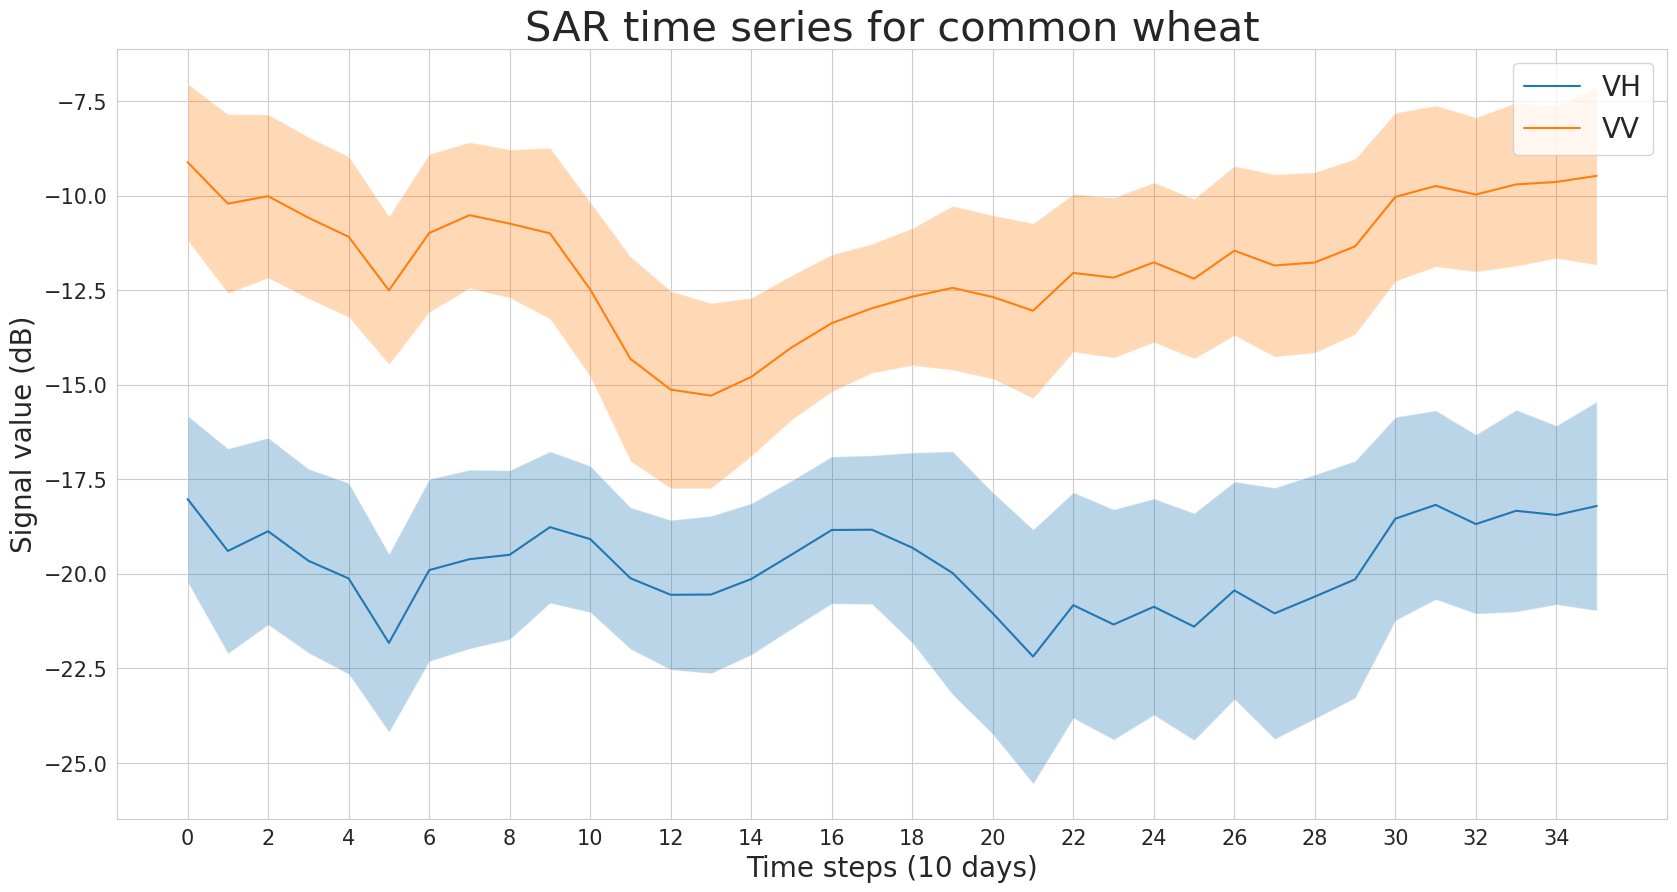

In [10]:
plt.figure(figsize=(20, 10))

title_font=30
legend_font=20
y_axis_font=20
x_axis_font=15
# band = 'B1'

for band in ['VH', 'VV']:
    mean = bands[band].mean(axis=0)
    std = bands[band].std(axis=0)
    plt.plot(mean, label=band)
    plt.fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.3)

plt.xlabel('Time steps (10 days)', fontsize=legend_font)
plt.ylabel('Signal value (dB)', fontsize=legend_font)
plt.title('SAR time series for common wheat', fontsize=title_font)
plt.xticks(np.arange(0, 36, 2), np.arange(0, 36, 2), fontsize=x_axis_font)
plt.yticks(fontsize=x_axis_font)
plt.legend(fontsize=legend_font)
plt.show()

Text(0.5, 1.0, 'Model classification accuracy')

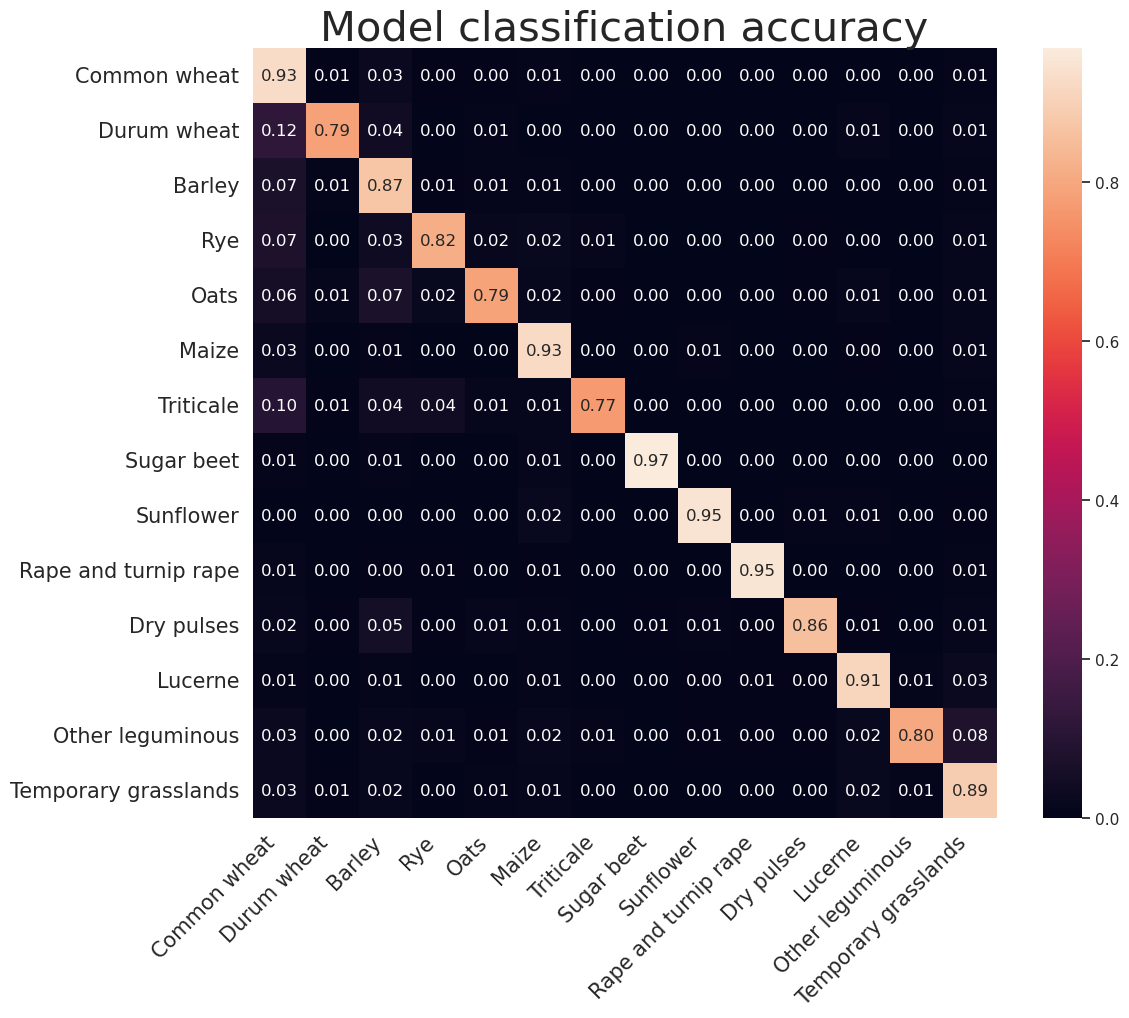

In [25]:
from sklearn.metrics import confusion_matrix

title_font=30
legend_font=15
axis_font=20
test_results_path = '../../preds.csv'
test_results = pd.read_csv(test_results_path)
pred = test_results['preds']
true = test_results['labels']
labels = [LUCAS2018_LEVEL2_CODES[x] for x in LUCAS_10_CLASSES.keys()]

plt.figure(figsize=(12, 10))

cf_matrix = confusion_matrix(
    true,
    pred,
    normalize='true'
    )

# fig = plt.figure(figsize=(9,7))
sns.set(font_scale=1) # Adjust to fit

sns.heatmap(
    cf_matrix, 
    annot=True, 
    xticklabels=labels,
    yticklabels=labels,
    fmt='.2f'    
)

plt.xticks(fontsize=y_axis_font-5, rotation=45, ha='right')
plt.yticks(fontsize=y_axis_font-5)
plt.title('Model classification accuracy', fontsize=title_font)

In [12]:
test_results.value_counts('country').index

Index(['France', 'Spain', 'Poland', 'Germany', 'Italy', 'Czech Republic',
       'Romania', 'Bulgaria', 'Latvia', 'Lithuania', 'Hungary', 'Sweden',
       'Denmark', 'Belgium', 'Austria', 'Finland', 'Slovakia', 'Greece',
       'Portugal', 'Ireland', 'Netherlands', 'Estonia', 'Croatia', 'Slovenia',
       'Luxembourg'],
      dtype='object', name='country')

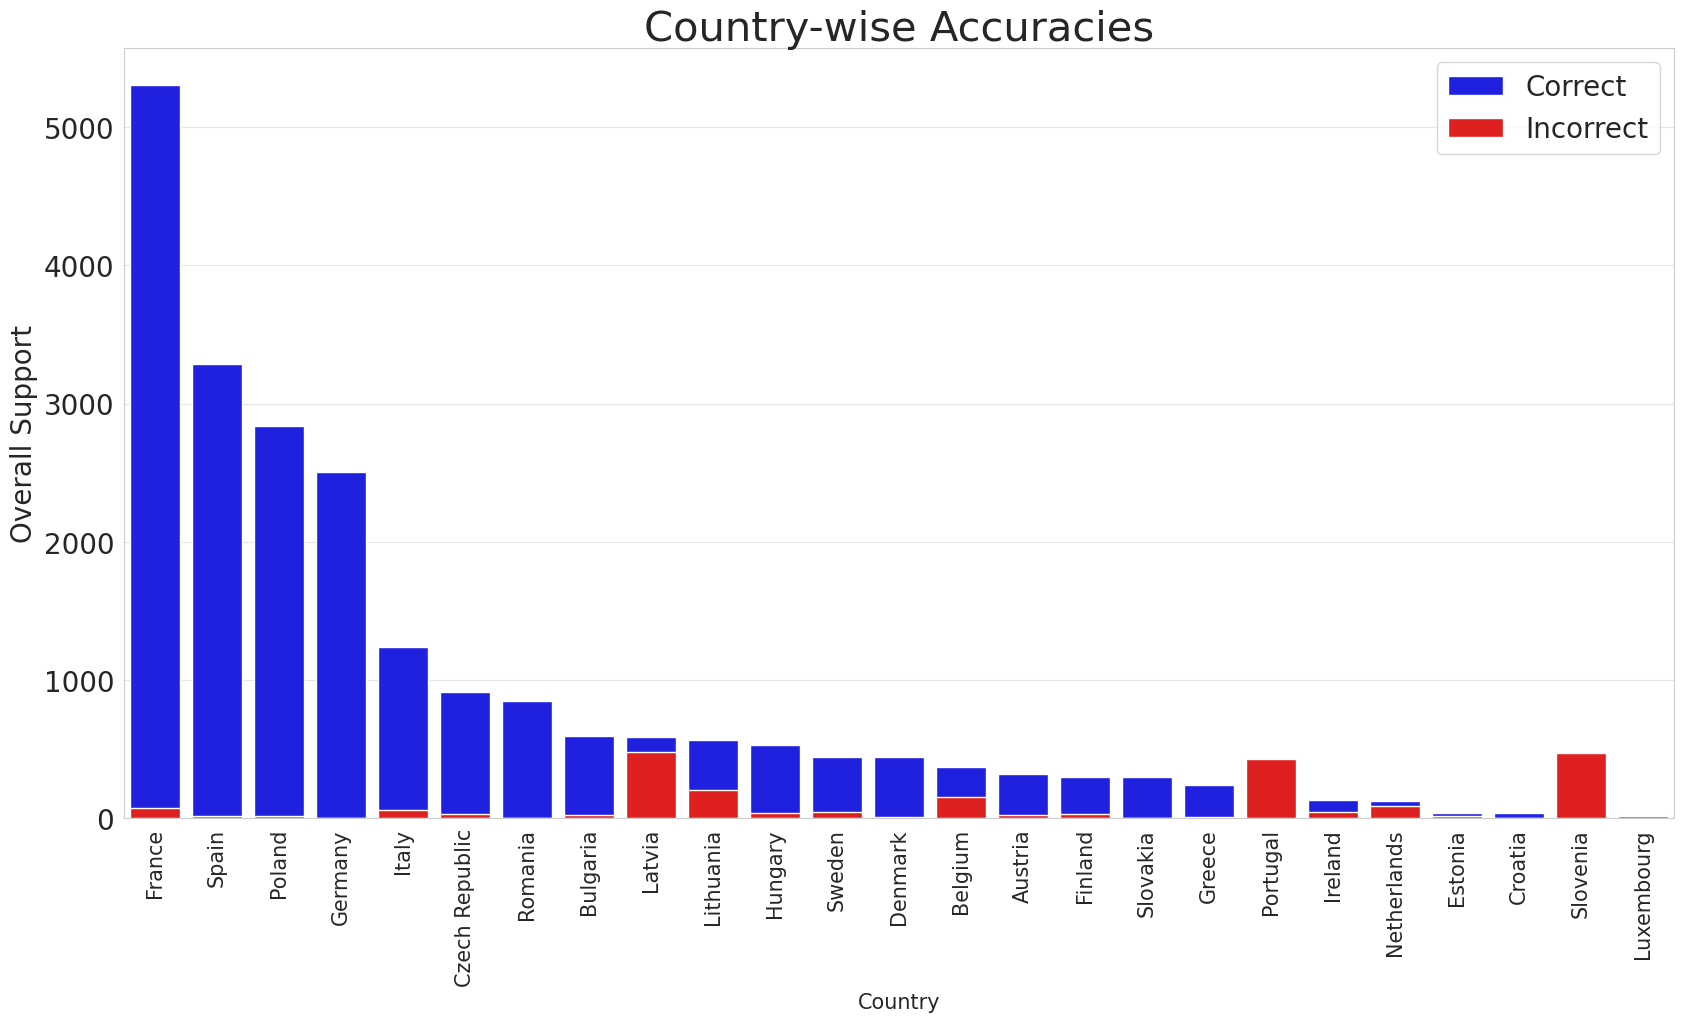

In [13]:
plt.figure(figsize=(20, 10))
plt.title('Country-wise Accuracies', fontsize=title_font)

# Calculate the overall support for each country
country_support = test_results['country'].value_counts()

# Calculate the correct and incorrect predictions for each country
correct_predictions = test_results[test_results['preds'] == test_results['labels']]['country'].value_counts()
incorrect_predictions = test_results[test_results['preds'] != test_results['labels']]['country'].value_counts()

# Combine the correct and incorrect predictions into a single dataframe
accuracy_df = pd.DataFrame({'Correct': correct_predictions, 'Incorrect': incorrect_predictions}).fillna(0)

# Plot the bar plot
sns.barplot(x=country_support.index, y=country_support, color='blue', label='Correct')
sns.barplot(x=country_support.index, y=accuracy_df['Incorrect'], color='red', label='Incorrect')

plt.xlabel('Country', fontsize=x_axis_font)
plt.ylabel('Overall Support', fontsize=y_axis_font)
plt.xticks(fontsize=x_axis_font, rotation=90)
plt.yticks(fontsize=y_axis_font)
plt.legend(fontsize=legend_font)
plt.grid(axis='y', alpha=0.5)
plt.show()